## Testing PyTorch with MNIST Fashion dataset
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

### Get PyTorch and MNIST Data

In [1]:
# Packages
# import tensorflow as tf
# from tensorflow import keras
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Get the training and testing data sets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

### Show some samples and extract feature/label data

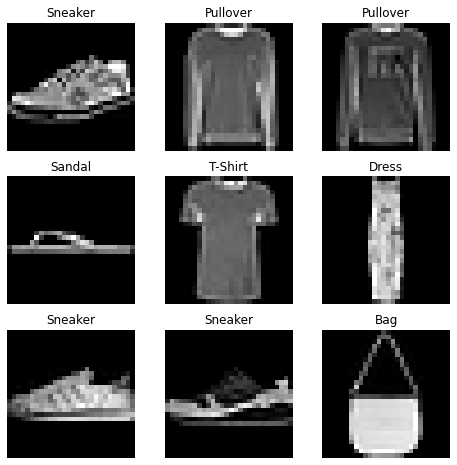

In [23]:
# Labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
num_classes = 10

# Create a 3x3 plot with random samples and labels
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


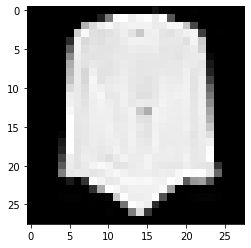

Label: 6


In [4]:
# Put the data into dataloaders for PyTorch
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

# Show a sample from the data along with shape info
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Create the Neural Net

In [5]:
# Ensures use of hardware accelerator, like a gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'Using {device} device')

Using cpu device


In [6]:
# Build a Neural Network to classify the MNISTFashion set
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


torch.Size([1, 28, 28])
torch.Size([28, 28])
Predicted class: Coat


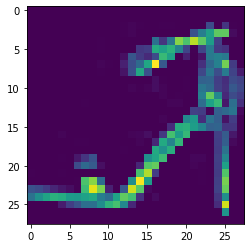

In [7]:
# Run the NN as is on random input
# X = torch.rand(1, 28, 28, device=device)
X = training_data[8][0]
# print(training_data[8])

print(X.size())
print(X.squeeze().size())

plt.imshow(X.squeeze())

logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {labels_map[y_pred.item()]}")

### Train the Model

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
# Functions to train and test the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
# Run a certain number of epochs for the training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301922  [    0/60000]
loss: 2.276100  [ 6400/60000]
loss: 2.275770  [12800/60000]
loss: 2.252774  [19200/60000]
loss: 2.231853  [25600/60000]
loss: 2.225052  [32000/60000]
loss: 2.213518  [38400/60000]
loss: 2.178451  [44800/60000]
loss: 2.181705  [51200/60000]
loss: 2.174981  [57600/60000]
Test Error: 
 Accuracy: 43.6%, Avg loss: 2.142286 

Epoch 2
-------------------------------
loss: 2.142115  [    0/60000]
loss: 2.116120  [ 6400/60000]
loss: 2.086024  [12800/60000]
loss: 2.061084  [19200/60000]
loss: 2.047989  [25600/60000]
loss: 1.995861  [32000/60000]
loss: 1.974024  [38400/60000]
loss: 1.920728  [44800/60000]
loss: 1.880556  [51200/60000]
loss: 1.877553  [57600/60000]
Test Error: 
 Accuracy: 61.0%, Avg loss: 1.858542 

Epoch 3
-------------------------------
loss: 1.846748  [    0/60000]
loss: 1.838914  [ 6400/60000]
loss: 1.767080  [12800/60000]
loss: 1.742936  [19200/60000]
loss: 1.713504  [25600/60000]
loss: 1.704215  [32000/600

### How does the model do?

In [11]:
# Confusion Matrix from HW2
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, rotation_mode='anchor', ha = 'right')
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [12]:
model.eval()   # Make sure model is in eval mode

# Collect various pieces of data
pred_lab = np.array([])
pred_prob = np.array([])
test_labels = np.array([])

# Run the model over all test data
with torch.no_grad():
    for X, y in test_dataloader:
        pred = nn.Softmax(dim=1)(model(X))
        pred_lab = np.append(pred_lab, pred.argmax(1).tolist())
        pred_prob = np.append(pred_prob, [max(probs) for probs in pred.tolist()])
        test_labels = np.append(test_labels, y.tolist())

label_set = np.unique(test_labels)
label_names = np.array([labels_map[i] for i in label_set])

Confusion matrix, without normalization
[[793   6  20  96  10   1  54   1  19   0]
 [ 31 906  13  38  10   0   0   0   2   0]
 [ 19   1 672   9 230   0  42   0  26   1]
 [121 116   8 690  27   0  33   0   4   1]
 [ 21   6 359  77 506   0  17   0  14   0]
 [  1   0   1   3   0  15   0 505  11 464]
 [261   6 287  46 245   0 100   0  55   0]
 [  0   0   0   0   0   0   0 895   0 105]
 [  8   2  28  26   3   0   5  24 903   1]
 [  1   0   0   0   2   0   0  63   3 931]]


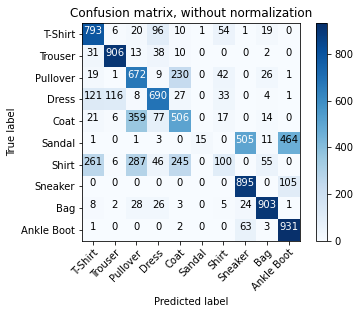

In [13]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(test_labels, pred_lab)
label_set = np.unique(test_labels)
plot_confusion_matrix(cnf_matrix, label_names,
                      title='Confusion matrix, without normalization')

In [14]:
# Confusion Matrix with pictures from HW2
import matplotlib.image as mpimg
def gen_err_predicted_fig( data, test_labels, pred_lab, pred_prob, label_set, label_names, figsize=(10, 10)):
    errNameMap = {}
    maxErrNameMap = {}
    cnt = 0
    for lab in label_set:
        for plab in label_set:
            if lab == plab:
                continue
            else:
                cIdx = np.nonzero(test_labels==lab)[0]
                errIdx = cIdx[ np.nonzero(pred_lab[cIdx]==plab)[0] ]
                errNameMap[(lab, plab)] = errIdx
                if len(errIdx) != 0:
                    errProb = np.max( pred_prob[errIdx] )
                    errFIdx = errIdx[ np.argmax( pred_prob[errIdx] ) ]
                    maxErrNameMap[(lab, plab)] = errFIdx
    title_font = {'fontname':'Arial', 'size':'16', 
                  'color':'black', 'weight':'bold'} 
    fig = plt.figure(figsize=figsize)
    num = len(label_set)
    for i in range(num*num):
        rIdx = i // num
        cIdx = i % num
        ax = plt.subplot(num, num, i+1)
        if rIdx == 0:
            ax.xaxis.set_label_position('top') 
            ax.set_xlabel( label_names[int(label_set[cIdx])], 
                           rotation=45, rotation_mode='anchor', ha = 'left' )
        if cIdx == 0:
            ax.yaxis.set_label_position('left')
            ax.set_ylabel( label_names[int(label_set[rIdx])],  
                           rotation=45, rotation_mode='anchor', ha = 'right' )
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.subplots_adjust(wspace=0, hspace=0)
        
        if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
            fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]    
            plt.imshow(data[fIdx][0].squeeze())
        else:
            plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
                     **title_font)
        
#         if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
#             fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]            
#             folderName = label_names[test_labels[fIdx]]            
#             fID = test_sample_ids[fIdx]
#             img=mpimg.imread( srcPath + '/' + folderName.decode('utf-8') + '/' + \
#                              fID.decode('utf-8') + '.jpg')    
#             plt.imshow(img)  # The AxesGrid object work as a list of axes.
#         else:
#             plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
#                      **title_font)
    
    plt.show()

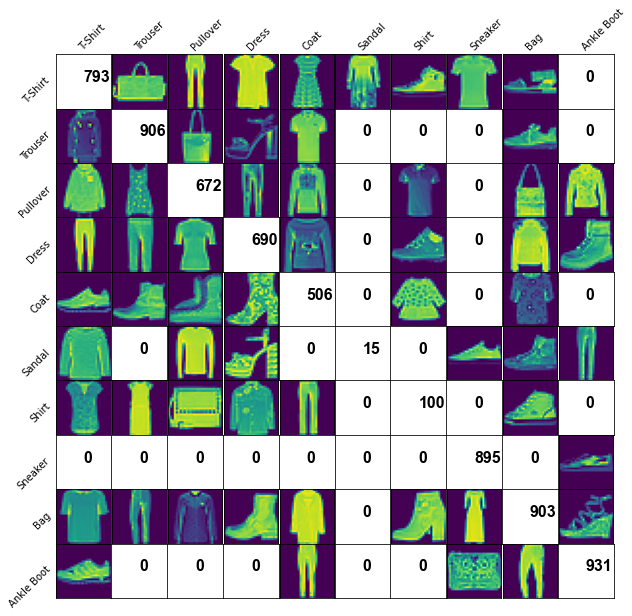

In [15]:

# print(label_set)
# print(pred_lab)
gen_err_predicted_fig( test_data, test_labels, pred_lab, pred_prob, label_set, label_names)

### Try a CNN

torch.Size([1, 1, 28, 28])
torch.Size([1, 6, 26, 26])
torch.Size([1, 6, 13, 13])
torch.Size([1, 16, 11, 11])
torch.Size([1, 16, 5, 5])


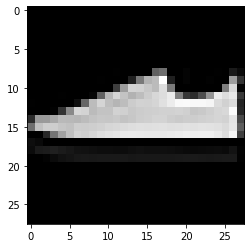

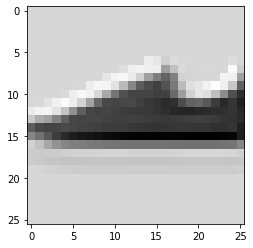

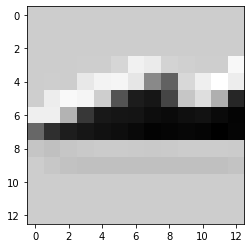

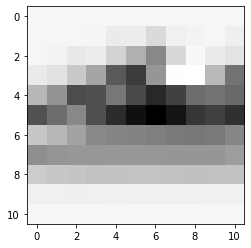

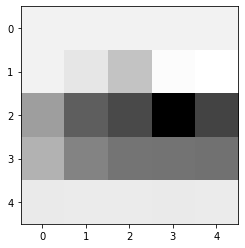

In [69]:
# Playing around with convolutions and pooling

# Datapoint
sample_idx = torch.randint(len(training_data), size=(1,)).item()
x = training_data[sample_idx][0]
plt.figure()
plt.imshow(x.squeeze(), cmap="gray")
print(x.unsqueeze(0).size())

# Layers
conv1 = nn.Conv2d(1, 6, 3)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 3)

with torch.no_grad():
    x = conv1(x.unsqueeze(0))
    plt.figure()
    plt.imshow(x.squeeze()[0], cmap="gray")
    print(x.size())
    
    x = pool(x)
    plt.figure()
    plt.imshow(x.squeeze()[0], cmap="gray")
    print(x.size())
    
    x = conv2(x)
    plt.figure()
    plt.imshow(x.squeeze()[0], cmap="gray")
    print(x.size())
    
    x = pool(x)
    plt.figure()
    plt.imshow(x.squeeze()[0], cmap="gray")
    print(x.size())


In [85]:
# Build a Convolutional Neural Network to classify the MNISTFashion set
# adapted from https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py

import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)   # 1 color channel, output channel size 6, kernel size 3
        self.pool = nn.MaxPool2d(2, 2)    # kernel size 2, stride 2
        
        self.fc1 = nn.Linear(6 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
#         print(x.size())
        x = x.view(-1, 6 * 13 * 13)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x
    
model = ConvNet().to(device)
print(model)

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1014, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


torch.Size([1, 28, 28])
Predicted class: Sneaker


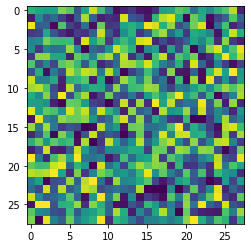

In [86]:
# Run the NN as is on random input
X = torch.rand(1, 28, 28, device=device)
# X = train_set[1][0]

# print(torch.equal(X[0], X[2]))
print(X.size())
plt.imshow(X.squeeze())

logits = model(X.unsqueeze(0))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {labels_map[y_pred.item()]}")

### Train the Model

In [87]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [88]:
# Functions to train and test the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [89]:
# Run a certain number of epochs for the training
epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302415  [    0/60000]
loss: 2.305375  [ 6400/60000]
loss: 2.310825  [12800/60000]
loss: 2.300249  [19200/60000]
loss: 2.300646  [25600/60000]
loss: 2.300886  [32000/60000]
loss: 2.293304  [38400/60000]
loss: 2.289309  [44800/60000]
loss: 2.284093  [51200/60000]
loss: 2.288965  [57600/60000]
Test Error: 
 Accuracy: 17.4%, Avg loss: 2.288143 

Epoch 2
-------------------------------
loss: 2.284210  [    0/60000]
loss: 2.283296  [ 6400/60000]
loss: 2.282132  [12800/60000]
loss: 2.276695  [19200/60000]
loss: 2.286310  [25600/60000]
loss: 2.277884  [32000/60000]
loss: 2.267611  [38400/60000]
loss: 2.272696  [44800/60000]
loss: 2.272182  [51200/60000]
loss: 2.274076  [57600/60000]
Test Error: 
 Accuracy: 40.0%, Avg loss: 2.264142 

Epoch 3
-------------------------------
loss: 2.261229  [    0/60000]
loss: 2.256934  [ 6400/60000]
loss: 2.243915  [12800/60000]
loss: 2.253582  [19200/60000]
loss: 2.244921  [25600/60000]
loss: 2.247251  [32000/600

### How does the model do?

In [90]:
# Calculate Accuracies
# from https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            if (i >= len(labels)): break
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(num_classes):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {labels_map[i]}: {acc} %')

Accuracy of the network: 50.3 %
Accuracy of T-Shirt: 14.3 %
Accuracy of Trouser: 48.6 %
Accuracy of Pullover: 95.7 %
Accuracy of Dress: 87.4 %
Accuracy of Coat: 0.0 %
Accuracy of Sandal: 0.0 %
Accuracy of Shirt: 0.3 %
Accuracy of Sneaker: 72.9 %
Accuracy of Bag: 85.7 %
Accuracy of Ankle Boot: 98.1 %


In [91]:
# Confusion Matrix from HW2
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, rotation_mode='anchor', ha = 'right')
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [92]:
model.eval()   # Make sure model is in eval mode

# Collect various pieces of data
pred_lab = np.array([])
pred_prob = np.array([])
test_labels = np.array([])

# Run the model over all test data
with torch.no_grad():
    for X, y in test_dataloader:
        pred = nn.Softmax(dim=1)(model(X))
        pred_lab = np.append(pred_lab, pred.argmax(1).tolist())
        pred_prob = np.append(pred_prob, [max(probs) for probs in pred.tolist()])
        test_labels = np.append(test_labels, y.tolist())
        
label_set = np.unique(test_labels)
label_names = np.array([labels_map[i] for i in label_set])

Confusion matrix, without normalization
[[143   1 393 438   0   0   2   2  18   3]
 [  1 486  23 488   0   0   0   0   2   0]
 [  1   0 957  25   0   0   2   0  15   0]
 [  2  39  81 874   0   0   0   0   4   0]
 [  0   0 854 137   0   0   0   0   8   1]
 [  1   0   0   1   0   0   0 338 164 496]
 [ 24   0 742 193   0   0   3   0  38   0]
 [  0   0   0   0   0   0   0 729  23 248]
 [  0   0  76  47   0   0   9   7 857   4]
 [  0   0   0   6   0   0   0  11   2 981]]


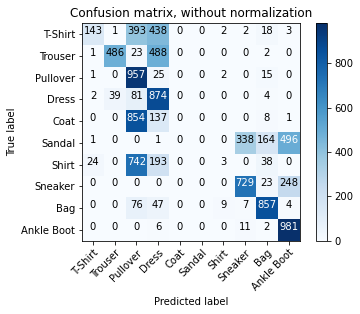

In [93]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(test_labels, pred_lab)
label_set = np.unique(test_labels)
plot_confusion_matrix(cnf_matrix, label_names,
                      title='Confusion matrix, without normalization')

In [94]:
# Confusion Matrix with pictures from HW2
import matplotlib.image as mpimg
def gen_err_predicted_fig( data, test_labels, pred_lab, pred_prob, label_set, label_names, figsize=(10, 10)):
    errNameMap = {}
    maxErrNameMap = {}
    cnt = 0
    for lab in label_set:
        for plab in label_set:
            if lab == plab:
                continue
            else:
                cIdx = np.nonzero(test_labels==lab)[0]
                errIdx = cIdx[ np.nonzero(pred_lab[cIdx]==plab)[0] ]
                errNameMap[(lab, plab)] = errIdx
                if len(errIdx) != 0:
                    errProb = np.max( pred_prob[errIdx] )
                    errFIdx = errIdx[ np.argmax( pred_prob[errIdx] ) ]
                    maxErrNameMap[(lab, plab)] = errFIdx
    title_font = {'fontname':'Arial', 'size':'16', 
                  'color':'black', 'weight':'bold'} 
    fig = plt.figure(figsize=figsize)
    num = len(label_set)
    for i in range(num*num):
        rIdx = i // num
        cIdx = i % num
        ax = plt.subplot(num, num, i+1)
        if rIdx == 0:
            ax.xaxis.set_label_position('top') 
            ax.set_xlabel( label_names[int(label_set[cIdx])], 
                           rotation=45, rotation_mode='anchor', ha = 'left' )
        if cIdx == 0:
            ax.yaxis.set_label_position('left')
            ax.set_ylabel( label_names[int(label_set[rIdx])],  
                           rotation=45, rotation_mode='anchor', ha = 'right' )
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.subplots_adjust(wspace=0, hspace=0)
        
        if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
            fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]    
            plt.imshow(data[fIdx][0].squeeze())
        else:
            plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
                     **title_font)
        
#         if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
#             fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]            
#             folderName = label_names[test_labels[fIdx]]            
#             fID = test_sample_ids[fIdx]
#             img=mpimg.imread( srcPath + '/' + folderName.decode('utf-8') + '/' + \
#                              fID.decode('utf-8') + '.jpg')    
#             plt.imshow(img)  # The AxesGrid object work as a list of axes.
#         else:
#             plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
#                      **title_font)
    
    plt.show()

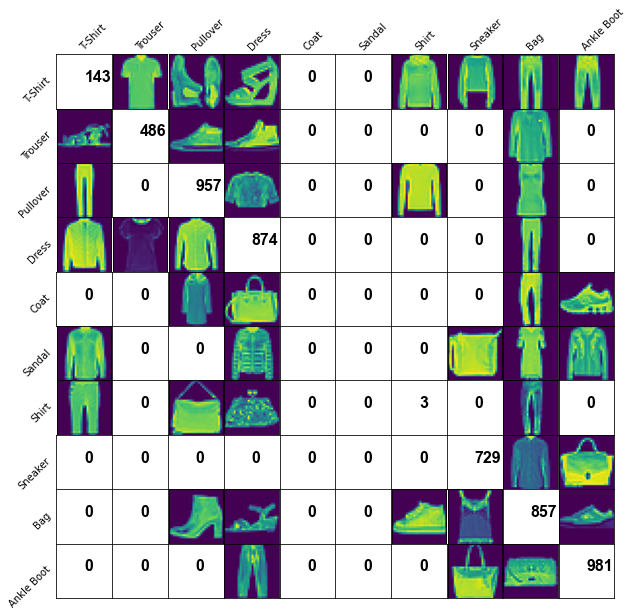

In [95]:

# print(label_set)
# print(pred_lab)
gen_err_predicted_fig( test_data, test_labels, pred_lab, pred_prob, label_set, label_names)